In [8]:
from io import StringIO
import pandas as pd
import numpy as np
import datetime
import time

Stock_list = pd.read_csv('name.csv')['name']
date = pd.read_csv('date.csv')['date']
Stock = pd.read_csv('model.csv')

Stock.sort_values(by=['證券代號','date'] , ascending=True, axis =0 , inplace=True)
Stock = Stock.reset_index(drop=True)

In [47]:
import math 
## 計算第 N 天後的價格差異
def day_price(df , days , list_):
    for i in range(len(df)-days):
        price_now = df.收盤價[i]
        price_tens = df.收盤價[i+days].tolist()
        
        # Abs加上就是純波動，不論正負 (漲跌)
        #diff = (price_tens-price_now)
        diff = abs(price_tens-price_now)
        
        ## by the number of * and / can modify the interval of price ratio
        rise = math.ceil((diff/price_now*100)+0.001)
        if abs(rise) > 10*days:
            continue
        list_.append(rise)    

In [100]:
def get_price_df (Stock , day , stock_list):
    test_ = []
    for i in Stock_list :
        s = Stock[Stock['證券代號'] == i].reset_index(drop=True)
        day_price(s,day,test_)

    # 計算方便用datframe算個數
    X = pd.DataFrame()
    X['ratio'] = test_
    #print(X.ratio.value_counts())
    
    # 移植數量與漲幅到新的 DF，在對漲幅sort 
    for_plt = pd.DataFrame()
    for_plt['number'] = X.ratio.value_counts().values
    for_plt['ratio'] = X.ratio.value_counts().index

    for_plt.sort_values(by=['ratio'] , ascending=True, axis =0 , inplace=True)
    for_plt = for_plt.reset_index(drop=True)
    return for_plt

In [101]:
for_plt = get_price_df (Stock , 3 , Stock_list)

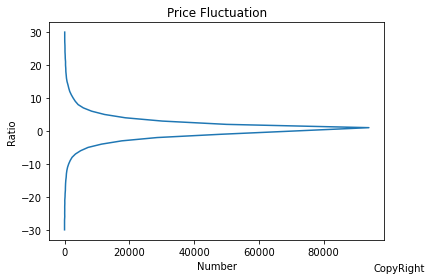

In [103]:
import matplotlib.pyplot as plt
plots = plt.plot(for_plt.number, for_plt.ratio)
plt.title('Price Fluctuation')
plt.xlabel('Number')
plt.ylabel('Ratio')
plt.figtext(0.995, 0.01, 'CopyRight', ha='right', va='bottom')
plt.show()

## plot rise part

In [94]:
import math
ratio_log = []
number_log = []

# 對數量、震幅取log
for i in range(len(for_plt.ratio)):
    if for_plt.ratio[i] > 0: 
        ratio_log.append(math.log(for_plt.ratio[i],10))
        number_log.append(math.log(for_plt.number[i],10))

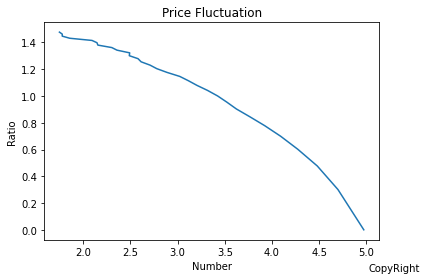

In [95]:
import matplotlib.pyplot as plt
plots = plt.plot(number_log, ratio_log)
plt.title('Price Fluctuation')
plt.xlabel('Number')
plt.ylabel('Ratio')
plt.figtext(0.995, 0.01, 'CopyRight', ha='right', va='bottom')
plt.show()

## plot drop part

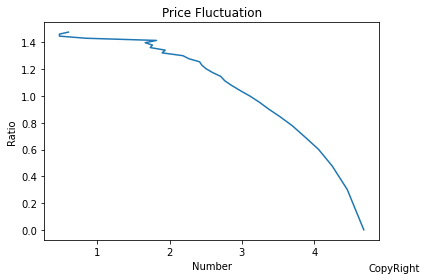

In [96]:
import math
drop_ratio_log = []
drop_number_log = []
for i in range(len(for_plt.ratio)):
    # 震幅 < 0 ，代表下跌
    if for_plt.ratio[i] < 0: 
        drop_ratio_log.append(math.log(-for_plt.ratio[i],10))
        drop_number_log.append(math.log(for_plt.number[i],10))

plots = plt.plot(drop_number_log, drop_ratio_log)
plt.title('Price Fluctuation')
plt.xlabel('Number')
plt.ylabel('Ratio')
plt.figtext(0.995, 0.01, 'CopyRight', ha='right', va='bottom')
plt.show()

Text(0.5, 1.0, 'Rise vs Fall ')

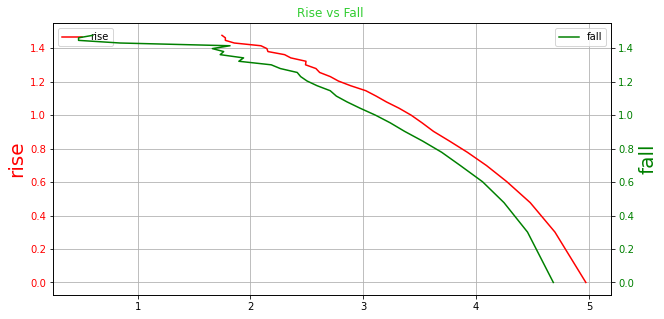

In [98]:
## 繪製重疊圖，方便漲跌比對

fig,ax=plt.subplots(figsize=(10,5))
ax.plot(number_log, ratio_log,color='red',label='rise')
ax.set_ylabel('rise',color='red',fontsize=20)
ax.tick_params(axis='y',labelcolor='red')
plt.grid()
ax.legend(loc='upper left')

ax2=ax.twinx()
ax2.plot(drop_number_log, drop_ratio_log,color='green',label='fall')
ax2.set_ylabel('fall',color='green',fontsize=20)
ax2.tick_params(axis='y',labelcolor='green')
ax2.legend(loc='upper right')

plt.title('Rise vs Fall ', color='limegreen')


In [142]:
## 設定股票篩選的條件，技術、籌碼指標我大概都試過了，沒甚麼用

def day_price(df , days , list_):
    for i in range(len(df)-days):
        # 多了設置條件，條件不合就不要這天的資訊
        if df['MA5 slope'][i] < 0 :
            continue
        elif df['UD60'][i] <= 0.05 :
            continue
        elif df['連漲跌'][i] >= 3 or  df['連漲跌'][i] <= 0:
            continue
        elif df['均線糾結1'][i] == 0 :
            continue
        elif df['成交金額'][i] < 300000000 :
            continue
        price_now = df.收盤價[i]
        price_tens = df.收盤價[i+days].tolist()
        diff = (price_tens-price_now)
        rise = math.ceil((diff/price_now*100)+0.001)
        if abs(rise) > 10*days:
            continue
        list_.append(rise)    

In [143]:
for_plt = get_price_df (Stock , 3 , Stock_list)

In [144]:
ratio_log = []
number_log = []
for i in range(len(for_plt.ratio)):
    if for_plt.ratio[i] > 0: 
        ratio_log.append(math.log(for_plt.ratio[i],10))
        number_log.append(math.log(for_plt.number[i],10))
drop_ratio_log = []
drop_number_log = []
for i in range(len(for_plt.ratio)):
    if for_plt.ratio[i] < 0: 
        drop_ratio_log.append(math.log(-for_plt.ratio[i],10))
        drop_number_log.append(math.log(for_plt.number[i],10))

Text(0.5, 1.0, 'Rise vs Fall ')

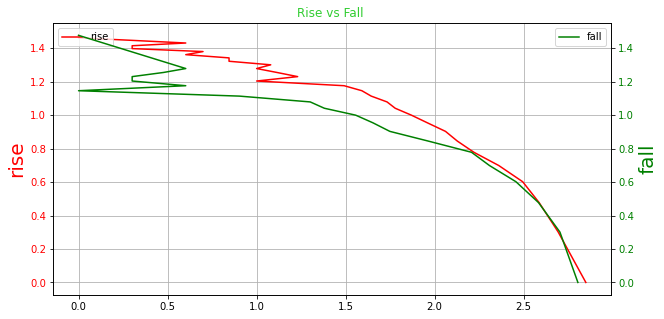

In [145]:
fig,ax=plt.subplots(figsize=(10,5))
ax.plot(number_log, ratio_log,color='red',label='rise')
ax.set_ylabel('rise',color='red',fontsize=20)
ax.tick_params(axis='y',labelcolor='red')
plt.grid()
ax.legend(loc='upper left')

ax2=ax.twinx()
ax2.plot(drop_number_log, drop_ratio_log,color='green',label='fall')
ax2.set_ylabel('fall',color='green',fontsize=20)
ax2.tick_params(axis='y',labelcolor='green')
ax2.legend(loc='upper right')

plt.title('Rise vs Fall ', color='limegreen')
